# Time Frequency Analysis

Calculate an induced time-frequency analysis of the main experimental contrast Example RQ: What oscillations underlay our effect of interest?

In [1]:
# general purpose
import numpy as np
import pandas as pd

# i/O
from scipy import io
from pathlib import Path
import datetime

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# testing
import unittest

# EEG stuff
import mne
import osfclient 
import mne_bids 
from mne_bids import (BIDSPath, read_raw_bids)

# EEG utils
import ccs_eeg_utils
import ccs_eeg_semesterproject

import configuration

- [Solution of exercise](https://github.com/s-ccs/course_eeg_SS2022/blob/main/exercises/solutions/ex9_tf.ipynb)
- [Frequency and time-frequency sensor analysis](https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html)

#####
031
#####
Reading /home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/Results/epochs/031-epo.fif ...
    Found the data of interest:
        t =    -226.56 ...     773.44 ms
        0 CTF compensation matrices available
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


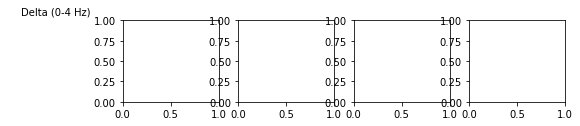

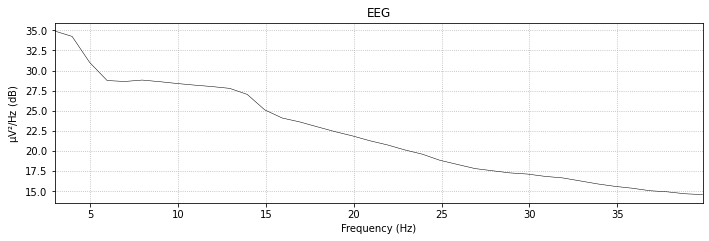

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [3]:
# get epochs:
subject_ids = [path.stem.replace('-epo', '') for path in Path(Path(configuration.path_results, 'epochs')).glob('*-epo.fif')]

for subject in subject_ids:
    print(f"#####\n{subject}\n#####")
    savepath_epochs_subj = f"{configuration.path_results}/epochs/{subject}-epo.fif"

    # load epochs from folder
    epochs = mne.read_epochs(savepath_epochs_subj)

    # frequency analysis
    epochs.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=False)

    # time-frequency representations
    freqs = np.logspace(*np.log10([5, 80]), num=25)
    n_cycles = freqs / 2.
    power_total = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False,n_jobs=4,average=True)

    # visualize all TFs at all electrodes to get an overview

    %matplotlib qt
    power_total.plot_topo(baseline=[-.2,0],mode="logratio",vmin=-2,vmax=2);

    power_total.plot_topo(baseline=[-.2,0],mode='percent',vmin=-4,vmax=4);

    # visualize evoked, total and induced for electrode

    epochs_induced = epochs.copy()
    #epochs_induced._data = epochs_induced._data  - epochs_induced.average().data # but we are using the offocial way here
    epochs_induced.subtract_evoked()

    power_induced = mne.time_frequency.tfr_morlet(epochs_induced, freqs=freqs, n_cycles=n_cycles, return_itc=False,n_jobs=1,average=True,picks=configuration.pick)

    power_induced

    %matplotlib qt
    power_evoked = mne.combine_evoked([power_total,power_induced],weights=[1,-1])

    mode = "percent"
    bsl = [-0.5,0]
    cmin = -3
    cmax = -cmin
    power_total.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=cmin,vmax=cmax)
    power_induced.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=cmin,vmax=cmax)
    power_evoked.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=cmin,vmax=cmax);

    power_evoked.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=-20,vmax=20);

    power_total.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=-1,vmax=1)